# **Install Dependencies**

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [ ]:
!pip install sacrebleu  rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9a030a2e5f32185059d66ee0387d8d11ea92d5e364496007e7b89b7d010caf7f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


# **Import Libraries**

In [ ]:
import torch
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    TrainerCallback,
)
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
from rouge_score import rouge_scorer
import json
import glob
import time
import unicodedata
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings
warnings.filterwarnings('ignore')

2025-05-02 02:32:55.800774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746153176.105505      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746153176.180547      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Analysis and Cleaning**

In [ ]:
df = pd.read_parquet("hf://datasets/damerajee/english-to-hindi-l/data/train-00000-of-00001.parquet")

In [ ]:
df.head()

,english_sentence,hindi_sentence
0,When it is said to him: 'Fear Allah' egotism t...,"और जब उससे कहा जाता है, ""अल्लाह से डर"", तो अहं..."
1,This profile exists already.,यह प्रोफ़ाइल पहले से ही है.
2,Halo with Ornamental Borde,विवरण: एक पारंपरिक कमल के फूल के साथ पत्थर की ...
3,and the jinn We had created before from flamin...,और हम ही ने जिन्नात को आदमी से (भी) पहले वे धु...
4,"Ladies and Gentlemen, the Government of India ...",शहरीकरण की तेज गति के साथ अवसंरचना और सेवाओं क...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786788 entries, 0 to 1786787
Data columns (total 2 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   english_sentence  object
 1   hindi_sentence    object
dtypes: object(2)
memory usage: 27.3+ MB


In [ ]:
df.isnull().sum()

english_sentence    0
hindi_sentence      0
dtype: int64

In [ ]:
df.duplicated().sum()

238016

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
len(df)

1548772

In [ ]:
def clean(text: str) -> str:
    text = unicodedata.normalize("NFKC", text)

    text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')

    text = re.sub(r'\d+', '', text)

    # Keep English, Hindi (Devanagari block), basic punctuation, and whitespace
    text = re.sub(r'[^\w\s\u0900-\u097F.,!?;:]', '', text)

    text = re.sub(r'\s+', ' ', text)

    return text.strip()
df['english_sentence']=df['english_sentence'].apply(clean)
df['hindi_sentence']=df['hindi_sentence'].apply(clean)

In [ ]:
df.head(10)

,english_sentence,hindi_sentence
0,When it is said to him: Fear Allah egotism tak...,"और जब उससे कहा जाता है, अल्लाह से डर, तो अहंका..."
1,This profile exists already.,यह प्रोफ़ाइल पहले से ही है.
2,Halo with Ornamental Borde,विवरण: एक पारंपरिक कमल के फूल के साथ पत्थर की ...
3,and the jinn We had created before from flamin...,और हम ही ने जिन्नात को आदमी से भी पहले वे धुएँ...
4,"Ladies and Gentlemen, the Government of India ...",शहरीकरण की तेज गति के साथ अवसंरचना और सेवाओं क...
5,"Have you then considered Al Lat, and Al Uzza t...",तो क्या तुमने लात और उज़्ज़ा
6,Escalation in demand will provide traders an o...,मांग में वृद्धि व्यापारियों को कीमतें बढाने का...
7,He understood the pity and the beauty of life ...,वे जीवन में अनुकम्पा और सौन्दर्य के महत्व को स...
8,Fast Track Court The Additional Sessions Court...,फास्ट ट्रेक कोर्टये अतिरिक्त सत्र न्यायालय है ...
9,He was working as a quality controller in the ...,वह खाद्य उत्पादन कारखाने में गुणवत्ता नियंत्रक...


# **Data Preparation**

* Data Splitting

In [ ]:
df['total_length'] = df['english_sentence'].str.len() + df['hindi_sentence'].str.len()
df = df.sort_values(by='total_length', ascending=False).head(30000).reset_index(drop=True)
df.drop(columns='total_length', inplace=True)

train_df = df.iloc[:10000]
val_df = df.iloc[25000:27000]
test_df = df.iloc[28000:30000]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 10000 rows
Validation set: 2000 rows
Test set: 2000 rows


* Model and Tokenizer Initialization

In [ ]:
model_name="Helsinki-NLP/opus-mt-en-hi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
print(f"Number of encoder layers: {len(model.model.encoder.layers)}")
print(f"Number of decoder layers: {len(model.model.decoder.layers)}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/all_params:.2%})")

Number of encoder layers: 6
Number of decoder layers: 6
Trainable parameters: 76,381,184 (100.00%)


In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

model.safetensors:   0%|          | 0.00/306M [00:00<?, ?B/s]

* Data Preprocessing

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
def preprocess_function(examples):
    inputs = examples["english_sentence"]
    targets = examples["hindi_sentence"]

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import os
!mkdir /kaggle/working/results
!mkdir /kaggle/working/results/best
!mkdir /kaggle/working/models

# **Callbacks - Helper Functions**

* Available Training Parameters  - Version-based

In [ ]:
try:
    import inspect
    print("Available parameters for Seq2SeqTrainingArguments:")
    sig = inspect.signature(Seq2SeqTrainingArguments.__init__)
    print(list(sig.parameters.keys()))
except Exception as e:
    print(f"Couldn't inspect parameters: {e}")

Available parameters for Seq2SeqTrainingArguments:
['self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 

* Evaluation Metrics

In [ ]:
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
def compute_metrics(eval_pred):
    preds, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    bleu_result = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )

    rouge_result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    result = {
        "bleu": bleu_result["bleu"],
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
    }

    return result

* In-Training Evaluation Callbacks

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

class PrintEpochCallback(TrainerCallback):
    def __init__(self):
        self.epoch_start_time = None

    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        print(f"Starting Epoch {state.epoch:.2f}")

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.epoch_start_time:
            duration = time.time() - self.epoch_start_time
            print(f"Epoch {state.epoch-1:.2f} time: {duration:.2f} seconds")

class MemoryCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"[Step {state.global_step}] Allocated: {allocated:.2f} GB | Reserved: {reserved:.2f} GB")

class EvalEveryNStepsCallback(TrainerCallback):
    def __init__(self, eval_steps=500):
        self.eval_steps = eval_steps

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.eval_steps == 0 and state.global_step != 0:
            control.should_evaluate = True
        if state.global_step == state.max_steps:
            control.should_evaluate = True

        return control

In [ ]:
import os
os.environ["WANDB_MODE"] = "offline"

* Hyperparameters Tuning Function

In [ ]:
def run_hyperparameter_tuning():
    param_grid = {
        "learning_rate": [5e-5,2e-5],
        "batch_size": [16,4,8],
        "weight_decay": [0.1,0.01]
    }

    eval_bleu_scores = []
    param_combinations = []

    trial_number = 0

    learning_rates = param_grid["learning_rate"]
    batch_sizes = param_grid["batch_size"]
    weight_decays = param_grid["weight_decay"]

    for lr in learning_rates:
        for bs in batch_sizes:
            for wd in weight_decays:

                print(f"Running trial {trial_number} with parameters:")
                print(f"  - learning_rate: {lr}")
                print(f"  - batch_size: {bs}")
                print(f"  - weight_decay: {wd}")

                params = {
                    "learning_rate": lr,
                    "batch_size": bs,
                    "weight_decay": wd,
                }
                param_combinations.append(params)

                training_args = Seq2SeqTrainingArguments(
                    output_dir=None,
                    learning_rate=lr,
                    per_device_train_batch_size=bs,
                    per_device_eval_batch_size=bs,
                    weight_decay=wd,
                    num_train_epochs=5,
                    adam_beta1=0.95,
                    max_grad_norm=0.5,
                    predict_with_generate=True,
                    save_steps=100,
                    save_total_limit=1,
                    generation_num_beams=5,
                    metric_for_best_model="bleu",
                    greater_is_better=True,
                )

                trainer = Seq2SeqTrainer(
                    model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=tokenizer,
                    data_collator=data_collator,
                    compute_metrics=compute_metrics,
                )

                trainer.train()

                eval_result = trainer.evaluate()
                bleu_score = eval_result["eval_bleu"]

                eval_bleu_scores.append(bleu_score)

                print(f"Trial {trial_number} completed with BLEU score: {bleu_score}")
                trial_number += 1

    best_idx = eval_bleu_scores.index(max(eval_bleu_scores))
    best_params = param_combinations[best_idx]
    best_bleu = eval_bleu_scores[best_idx]

    print("\nHyperparameters tuning completed!")
    print(f"Best BLEU score: {best_bleu}")
    print("Best parameters:")
    for param, value in best_params.items():
        print(f"  - {param}: {value}")

    return eval_bleu_scores, param_combinations, best_params

# **Hyperparameters Tuning**

* Tuning

In [ ]:
bleu_scores, parameters, best_params = run_hyperparameter_tuning()

Running trial 0 with parameters:
  - learning_rate: 5e-05
  - batch_size: 16
  - weight_decay: 0.1


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Step,Training Loss
500,2.785000
1000,2.205300
1500,2.017000


Trial 0 completed with BLEU score: 0.22339202001245728
Running trial 1 with parameters:
  - learning_rate: 5e-05
  - batch_size: 16
  - weight_decay: 0.01


Step,Training Loss
500,1.852600
1000,1.629800
1500,1.539200


Trial 1 completed with BLEU score: 0.221905513730126
Running trial 2 with parameters:
  - learning_rate: 5e-05
  - batch_size: 4
  - weight_decay: 0.1


Step,Training Loss
500,1.609800
1000,1.608000
1500,1.501500
2000,1.403700
2500,1.367700
3000,1.241200
3500,1.266800
4000,1.179900
4500,1.144500
5000,1.148300


Trial 2 completed with BLEU score: 0.18329391890145863
Running trial 3 with parameters:
  - learning_rate: 5e-05
  - batch_size: 4
  - weight_decay: 0.01


Step,Training Loss
500,1.011400
1000,1.038500
1500,0.984400
2000,0.917200
2500,0.918900
3000,0.817200
3500,0.861900
4000,0.808800
4500,0.792600
5000,0.814800


Trial 3 completed with BLEU score: 0.1606352694831102
Running trial 4 with parameters:
  - learning_rate: 5e-05
  - batch_size: 8
  - weight_decay: 0.1


Step,Training Loss
500,0.845100
1000,0.803500
1500,0.741800
2000,0.709200
2500,0.677900
3000,0.630300


Trial 4 completed with BLEU score: 0.1499672434033014
Running trial 5 with parameters:
  - learning_rate: 5e-05
  - batch_size: 8
  - weight_decay: 0.01


Step,Training Loss
500,0.559400
1000,0.542200
1500,0.510000
2000,0.502800
2500,0.501500
3000,0.486800


Trial 5 completed with BLEU score: 0.14022739767406409
Running trial 6 with parameters:
  - learning_rate: 2e-05
  - batch_size: 16
  - weight_decay: 0.1


Step,Training Loss
500,0.485200
1000,0.465900
1500,0.458900


Trial 6 completed with BLEU score: 0.13878820433054403
Running trial 7 with parameters:
  - learning_rate: 2e-05
  - batch_size: 16
  - weight_decay: 0.01


Step,Training Loss
500,0.390800
1000,0.395600
1500,0.412300


Trial 7 completed with BLEU score: 0.13549504808218785
Running trial 8 with parameters:
  - learning_rate: 2e-05
  - batch_size: 4
  - weight_decay: 0.1


Step,Training Loss
500,0.327600
1000,0.364400
1500,0.358200
2000,0.331300
2500,0.350200
3000,0.310900
3500,0.345200
4000,0.329700
4500,0.335000
5000,0.361700


Trial 8 completed with BLEU score: 0.13480571919233808
Running trial 9 with parameters:
  - learning_rate: 2e-05
  - batch_size: 4
  - weight_decay: 0.01


Step,Training Loss
500,0.215600
1000,0.250200
1500,0.249000
2000,0.229400
2500,0.251300
3000,0.221600
3500,0.256800
4000,0.250100
4500,0.261500
5000,0.292800


Trial 9 completed with BLEU score: 0.1305758889213967
Running trial 10 with parameters:
  - learning_rate: 2e-05
  - batch_size: 8
  - weight_decay: 0.1


Step,Training Loss
500,0.214900
1000,0.224300
1500,0.222400
2000,0.235800
2500,0.258100
3000,0.276400


Trial 10 completed with BLEU score: 0.12746379796699628
Running trial 11 with parameters:
  - learning_rate: 2e-05
  - batch_size: 8
  - weight_decay: 0.01


Step,Training Loss
500,0.144400
1000,0.156900
1500,0.161500
2000,0.180700
2500,0.211000
3000,0.242500


Trial 11 completed with BLEU score: 0.12519726387783076

Hyperparameters tuning completed!
Best BLEU score: 0.22339202001245728
Best parameters:
  - learning_rate: 5e-05
  - batch_size: 16
  - weight_decay: 0.1


* Tuning BLEU Scores

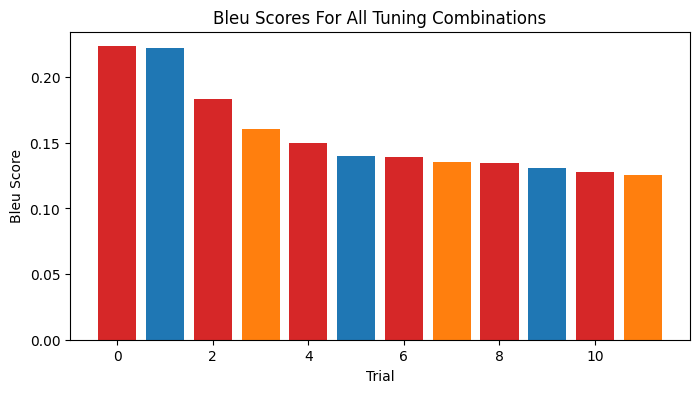

In [ ]:
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
plt.figure(figsize=(8, 4))
plt.bar(range(len(bleu_scores)), bleu_scores, color=bar_colors)
plt.xlabel("Trial")
plt.ylabel("Bleu Score")
plt.title("Bleu Scores For All Tuning Combinations")
plt.show()

* Tuning Best Parameters

In [ ]:
print("Best Parameters:")
for param, value in best_params.items():
        print(f"  - {param}: {value}")

Best Parameters:
  - learning_rate: 5e-05
  - batch_size: 16
  - weight_decay: 0.1
